# Prédiction du S&P500 avec un Réseau LSTM

## Projet Pédagogique - Deep Learning avec PyTorch

---

### Objectif du Projet

Ce notebook vous guide pas à pas dans la construction d'un modèle de **réseau de neurones récurrent LSTM** (Long Short-Term Memory) pour prédire les cours de l'indice boursier **S&P500**.

### Qu'est-ce que le S&P500 ?

Le **Standard & Poor's 500** est un indice boursier américain qui regroupe les 500 plus grandes entreprises cotées aux États-Unis (Apple, Microsoft, Amazon, etc.). C'est l'un des indicateurs les plus suivis de l'économie américaine.

### Pourquoi utiliser un LSTM pour les séries temporelles ?

Les réseaux de neurones classiques (feedforward) ne sont pas adaptés aux séries temporelles car ils ne conservent pas de "mémoire" des observations passées. Les **LSTM** ont été spécialement conçus pour résoudre ce problème :

```
┌─────────────────────────────────────────────────────────────────┐
│                    Architecture LSTM                            │
├─────────────────────────────────────────────────────────────────┤
│                                                                 │
│   Entrée (t-60)  →  Entrée (t-59)  → ... →  Entrée (t-1)  →  Sortie (t) │
│        ↓               ↓                        ↓              ↑    │
│   ┌────────┐      ┌────────┐             ┌────────┐            │    │
│   │  LSTM  │ ──→  │  LSTM  │  ──→ ... ──→│  LSTM  │────────────┘    │
│   │  Cell  │      │  Cell  │             │  Cell  │                 │
│   └────────┘      └────────┘             └────────┘                 │
│        │               │                      │                     │
│        └───── État caché (mémoire) ──────────┘                     │
│                                                                     │
│   → Le LSTM "se souvient" des patterns des 60 derniers jours       │
│     pour prédire le cours de demain                                │
└─────────────────────────────────────────────────────────────────────┘
```


---

In [519]:
# ============================================
# IMPORTS
# ============================================

# Manipulation de donnees
import pandas as pd
import numpy as np

# Telechargement des donnees boursieres
import yfinance as yf

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning avec PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Sauvegarde
import joblib
import json
import os
from datetime import datetime

# Configuration
import warnings
warnings.filterwarnings('ignore')

# Style des graphiques
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Seed pour reproductibilite
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device utilise : {device}")
print(f"PyTorch version : {torch.__version__}")

Device utilise : cpu
PyTorch version : 2.9.1+cpu


---

## Section 2 : Téléchargement des Données

### Comment fonctionne `yfinance` ?

`yfinance` est une bibliothèque Python qui permet de télécharger gratuitement les données historiques depuis Yahoo Finance. Le ticker `^GSPC` correspond à l'indice S&P500.

### Colonnes récupérées

| Colonne | Description |
|---------|-------------|
| **Open** | Prix d'ouverture du marché ce jour-là |
| **High** | Prix le plus haut atteint dans la journée |
| **Low** | Prix le plus bas atteint dans la journée |
| **Close** | Prix de clôture (celui qu'on veut prédire) |
| **Volume** | Nombre d'actions échangées |

In [520]:
# ============================================
# TELECHARGEMENT DES DONNEES
# ============================================

# Parametres
TICKER = "^GSPC"  
PERIOD = "5y"     

print(f"Telechargement des donnees {TICKER} sur {PERIOD}...")

# Telechargement via yfinance
df = yf.download(TICKER, period=PERIOD, progress=False)

# Suppression de la colonne Adj Close (pas necessaire)
if 'Adj Close' in df.columns:
    df = df.drop('Adj Close', axis=1)

# Aplatir les colonnes multi-index si necessaire
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# Creer le dossier data/ si necessaire
os.makedirs('data', exist_ok=True)

# Sauvegarder en CSV
df.to_csv('data/sp500_data.csv')

print(f"Donnees telechargees : {len(df)} jours de trading")
print(f"Periode : {df.index[0].strftime('%Y-%m-%d')} a {df.index[-1].strftime('%Y-%m-%d')}")
print(f"Colonnes : {list(df.columns)}")
print(f"\nDonnees sauvegardees dans data/sp500_data.csv")

Telechargement des donnees ^GSPC sur 5y...
Donnees telechargees : 1256 jours de trading
Periode : 2021-01-19 a 2026-01-16
Colonnes : ['Close', 'High', 'Low', 'Open', 'Volume']

Donnees sauvegardees dans data/sp500_data.csv


In [521]:
# Apercu des donnees
print("Premieres lignes :")
df.head()

Premieres lignes :


Price,Close,High,Low,Open,Volume
Date,,,,,
2021-01-19,3798.909912,3804.530029,3780.370117,3781.879883,5014440000
2021-01-20,3851.850098,3859.750000,3816.219971,3816.219971,4566190000
2021-01-21,3853.070068,3861.449951,3845.050049,3857.459961,4501760000
2021-01-22,3841.469971,3852.310059,3830.409912,3844.239990,5110890000
2021-01-25,3855.360107,3859.229980,3797.159912,3851.679932,7000840000


In [522]:
# Dernieres lignes
print("Dernieres lignes :")
df.tail()

Dernieres lignes :


Price,Close,High,Low,Open,Volume
Date,,,,,
2026-01-12,6977.270020,6986.330078,6934.069824,6944.120117,5019040000
2026-01-13,6963.740234,6985.830078,6938.770020,6977.410156,5091730000
2026-01-14,6926.600098,6941.299805,6885.740234,6937.410156,5530830000
2026-01-15,6944.470215,6979.339844,6937.930176,6969.459961,5114050000
2026-01-16,6941.799805,6967.299805,6939.560059,6960.540039,703536534


---

## Section 3 : Exploration des Données (EDA)

### Pourquoi explorer les données ?

Avant de construire un modèle, il est **essentiel** de comprendre les données :
- Y a-t-il des valeurs manquantes ?
- Quelle est la distribution des valeurs ?
- Y a-t-il des tendances ou des patterns visibles ?

Cette étape permet d'identifier des problèmes potentiels et de prendre des décisions éclairées pour le prétraitement.

In [523]:
# ============================================
# STATISTIQUES DESCRIPTIVES
# ============================================

print("Statistiques descriptives :")
df.describe()

Statistiques descriptives :


Price,Close,High,Low,Open,Volume
count,1256.000000,1256.000000,1256.000000,1256.000000,1.256000e+03
mean,4886.284816,4912.139162,4856.785427,4885.310081,4.413565e+09
std,907.740059,907.842719,907.057386,908.071300,9.922443e+08
min,3577.030029,3608.340088,3491.580078,3520.370117,0.000000e+00
25%,4154.782593,4173.317627,4124.392578,4153.177368,3.805080e+09
50%,4524.604980,4544.364990,4507.479980,4530.175049,4.235200e+09
75%,5622.087524,5650.769897,5586.140015,5624.045044,4.854230e+09
max,6977.270020,6986.330078,6939.560059,6977.410156,9.976520e+09


In [524]:
# Verification des valeurs manquantes
print("Valeurs manquantes par colonne :")
print(df.isnull().sum())
print(f"\nTotal de valeurs manquantes : {df.isnull().sum().sum()}")

Valeurs manquantes par colonne :
Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

Total de valeurs manquantes : 0


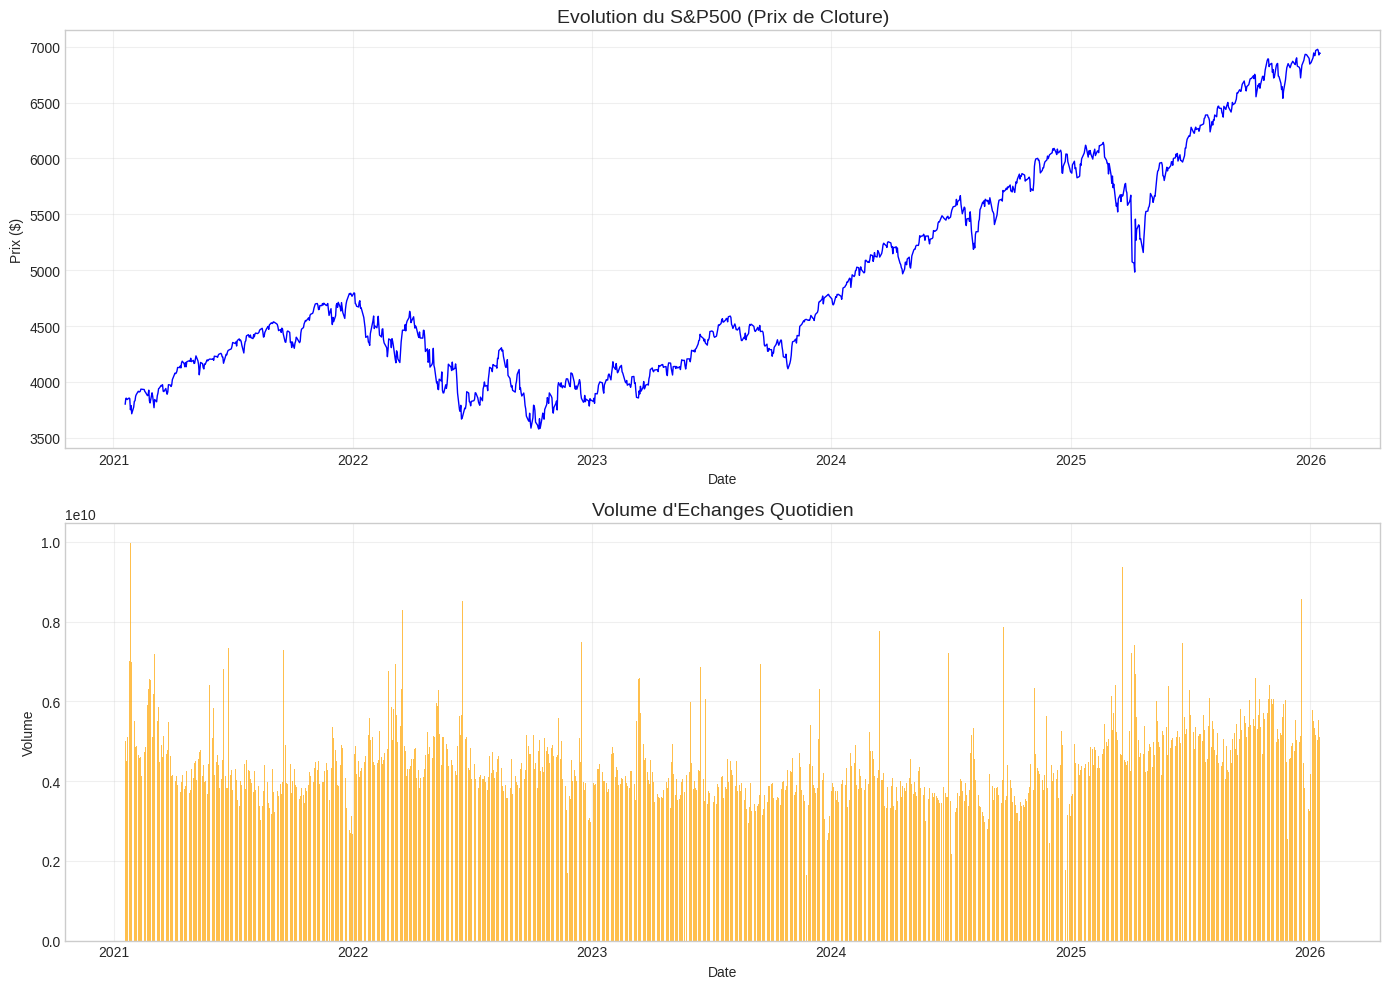

In [525]:
# ============================================
# VISUALISATION DU COURS
# ============================================

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Graphique 1 : Evolution du prix de cloture
axes[0].plot(df.index, df['Close'], color='blue', linewidth=1)
axes[0].set_title('Evolution du S&P500 (Prix de Cloture)', fontsize=14)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Prix ($)')
axes[0].grid(True, alpha=0.3)

# Graphique 2 : Volume d'echanges
axes[1].bar(df.index, df['Volume'], color='orange', alpha=0.7, width=1)
axes[1].set_title('Volume d\'Echanges Quotidien', fontsize=14)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Volume')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

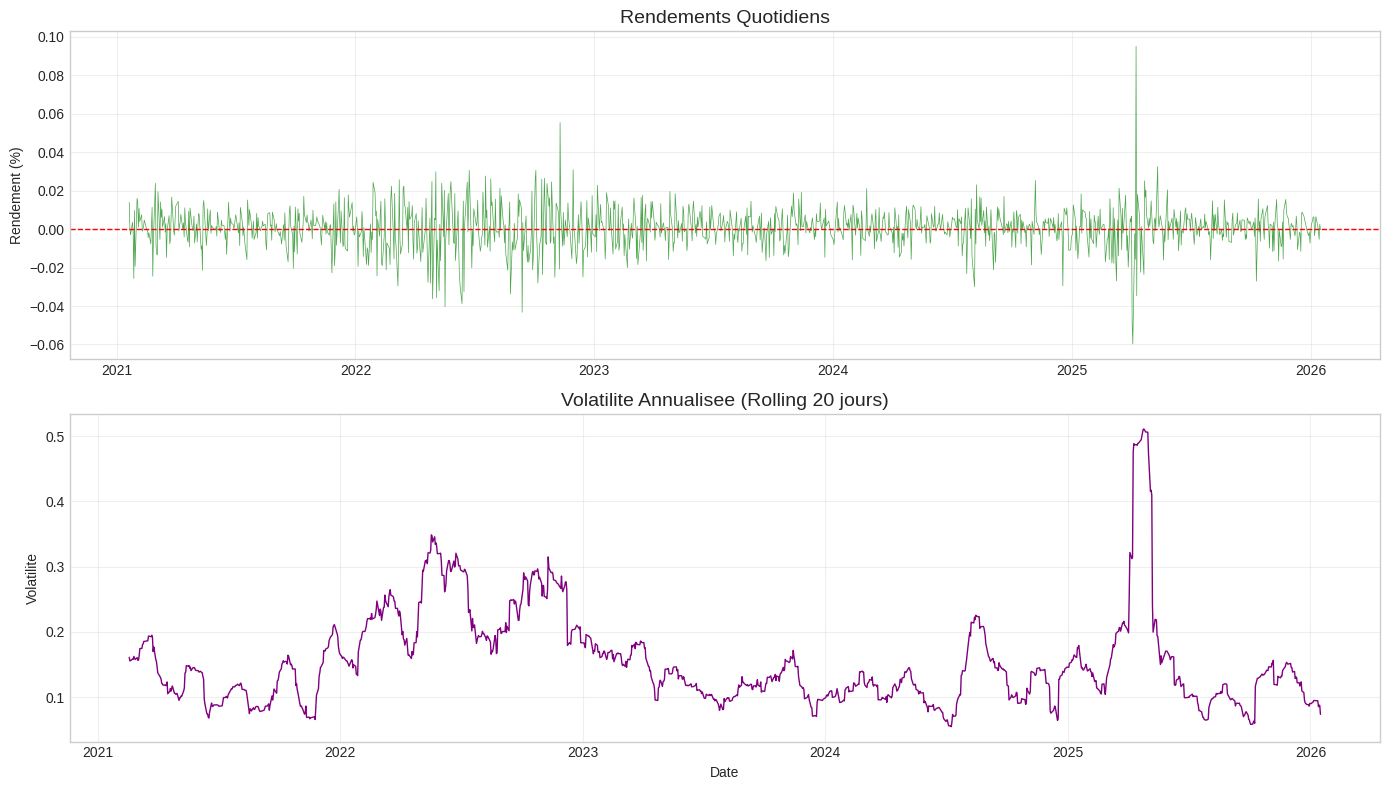

In [526]:
# ============================================
# ANALYSE DE LA VOLATILITE
# ============================================

# Calculer les rendements quotidiens
df['Returns'] = df['Close'].pct_change()

# Volatilite glissante sur 20 jours
df['Volatility'] = df['Returns'].rolling(window=20).std() * np.sqrt(252)  # Annualisee

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Rendements quotidiens
axes[0].plot(df.index, df['Returns'], color='green', alpha=0.7, linewidth=0.5)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0].set_title('Rendements Quotidiens', fontsize=14)
axes[0].set_ylabel('Rendement (%)')
axes[0].grid(True, alpha=0.3)

# Volatilite
axes[1].plot(df.index, df['Volatility'], color='purple', linewidth=1)
axes[1].set_title('Volatilite Annualisee (Rolling 20 jours)', fontsize=14)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Volatilite')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Supprimer les colonnes temporaires
df = df.drop(['Returns', 'Volatility'], axis=1)

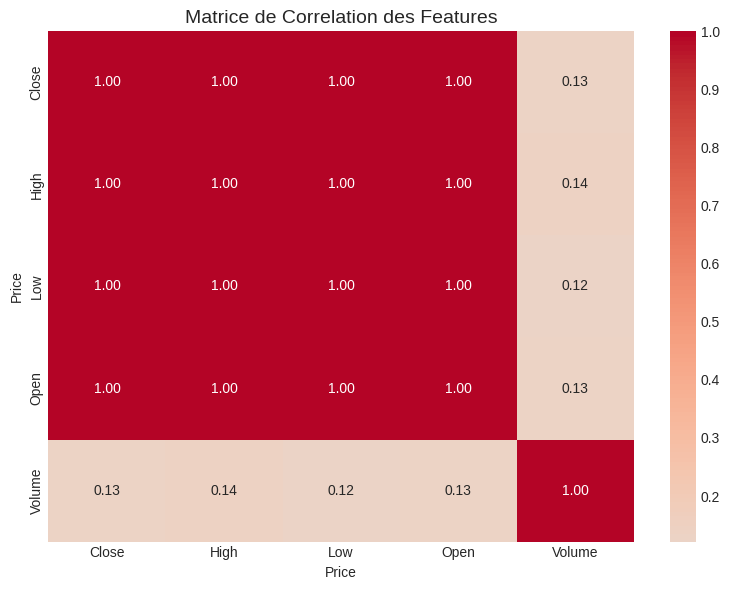

In [527]:
# ============================================
# MATRICE DE CORRELATION
# ============================================

plt.figure(figsize=(8, 6))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matrice de Correlation des Features', fontsize=14)
plt.tight_layout()
plt.show()

---

## Section 4 : Prétraitement des Données

### Pourquoi normaliser les données ?

Les réseaux de neurones fonctionnent mieux avec des données normalisées (entre 0 et 1) pour plusieurs raisons :

1. **Convergence plus rapide** : Les gradients sont plus stables
2. **Équité entre features** : Le Volume (~milliards) ne domine pas le Close (~milliers)
3. **Stabilité numérique** : Évite les problèmes de overflow/underflow

### MinMaxScaler

```
Formule : X_normalized = (X - X_min) / (X_max - X_min)

Exemple :
- Prix min = 2000$, Prix max = 5000$
- Prix actuel = 3500$
- Prix normalisé = (3500 - 2000) / (5000 - 2000) = 0.5
```

**Important** : On garde le scaler pour pouvoir "dénormaliser" les prédictions à la fin !

In [ ]:
# ============================================
# CONFIGURATION
# ============================================

CONFIG = {
    'sequence_length': 60,    # 60 jours pour predire le suivant (environ 2 mois)
    'hidden_size': 64,        # Nombre de neurones dans les couches LSTM
    'num_layers': 2,          # Nombre de couches LSTM empilees
    'dropout': 0.2,           # Taux de dropout pour la regularisation
    'batch_size': 32,         # Taille des batches
    'epochs': 250,            # Nombre d'epochs d'entrainement
    'learning_rate': 0.0001,   # Taux d'apprentissage
    'train_split': 0.8,       # 80% pour l'entrainement
    'test_split': 0.2,        # 20% pour le test
}

print("Configuration du modele :")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration du modele :
  sequence_length: 60
  hidden_size: 64
  num_layers: 2
  dropout: 0.2
  batch_size: 32
  epochs: 250
  learning_rate: 0.0001
  train_split: 0.8
  test_split: 0.2


In [529]:
# ============================================
# NORMALISATION DES DONNEES
# ============================================

# Selection des features (5 colonnes)
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = df[features].values

print(f"Features utilisees : {features}")
print(f"Shape des donnees : {data.shape}")

# Normalisation avec MinMaxScaler (valeurs entre 0 et 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

print(f"\nAvant normalisation :")
print(f"  Min : {data.min(axis=0)}")
print(f"  Max : {data.max(axis=0)}")

print(f"\nApres normalisation :")
print(f"  Min : {data_scaled.min(axis=0)}")
print(f"  Max : {data_scaled.max(axis=0)}")

Features utilisees : ['Open', 'High', 'Low', 'Close', 'Volume']
Shape des donnees : (1256, 5)

Avant normalisation :
  Min : [3520.37011719 3608.34008789 3491.58007812 3577.0300293     0.        ]
  Max : [6.97741016e+03 6.98633008e+03 6.93956006e+03 6.97727002e+03
 9.97652000e+09]

Apres normalisation :
  Min : [0. 0. 0. 0. 0.]
  Max : [1. 1. 1. 1. 1.]


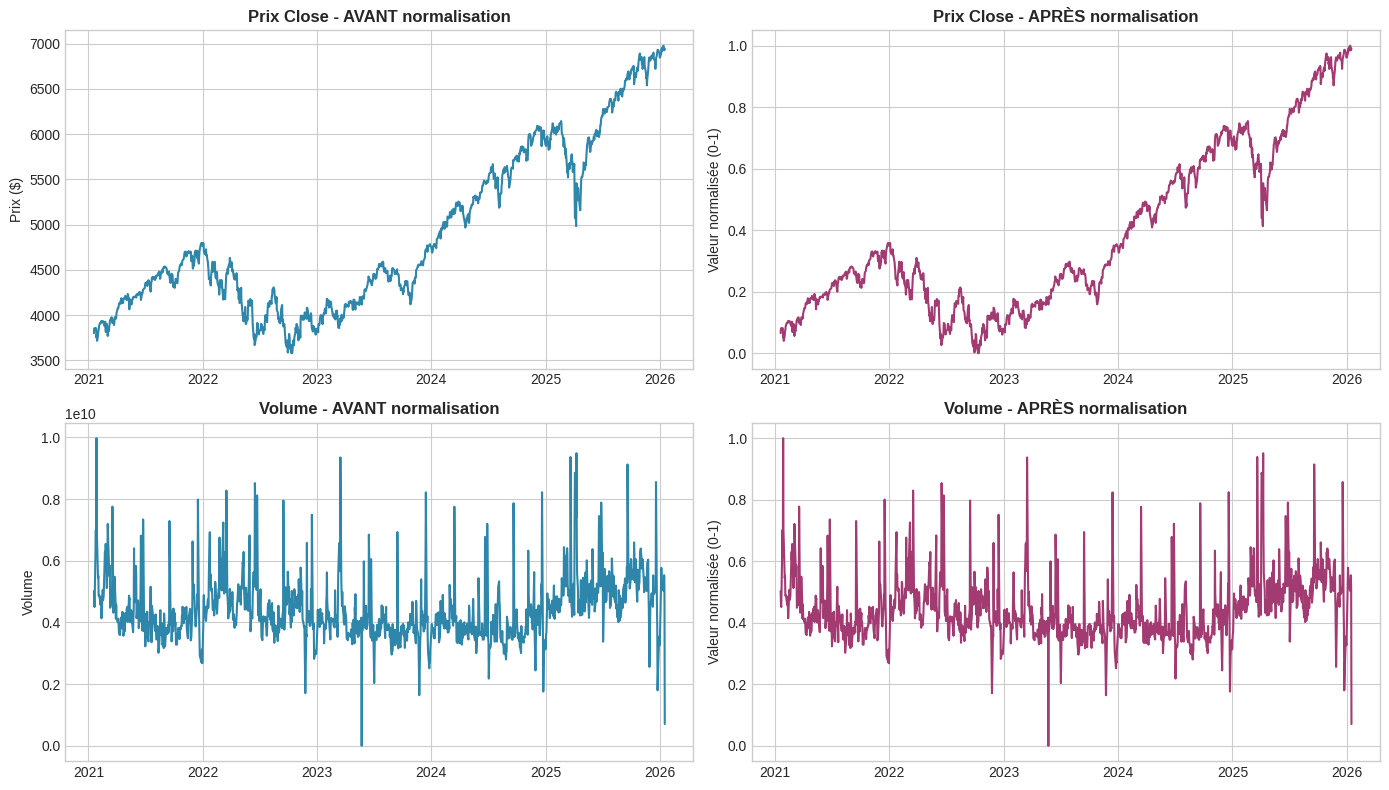


 Observation : Les formes sont identiques, seule l'échelle change
   Toutes les features sont maintenant entre 0 et 1


In [530]:
# ============================================
# VISUALISATION AVANT/APRÈS NORMALISATION
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Avant normalisation - Close
axes[0, 0].plot(df.index, df['Close'], color='#2E86AB')
axes[0, 0].set_title('Prix Close - AVANT normalisation', fontweight='bold')
axes[0, 0].set_ylabel('Prix ($)')

# Après normalisation - Close
axes[0, 1].plot(df.index, data_scaled[:, 3], color='#A23B72')  # Close est à l'index 3
axes[0, 1].set_title('Prix Close - APRÈS normalisation', fontweight='bold')
axes[0, 1].set_ylabel('Valeur normalisée (0-1)')

# Avant normalisation - Volume
axes[1, 0].plot(df.index, df['Volume'], color='#2E86AB')
axes[1, 0].set_title('Volume - AVANT normalisation', fontweight='bold')
axes[1, 0].set_ylabel('Volume')

# Après normalisation - Volume
axes[1, 1].plot(df.index, data_scaled[:, 4], color='#A23B72')  # Volume est à l'index 4
axes[1, 1].set_title('Volume - APRÈS normalisation', fontweight='bold')
axes[1, 1].set_ylabel('Valeur normalisée (0-1)')

plt.tight_layout()
plt.show()

print("\n Observation : Les formes sont identiques, seule l'échelle change")
print("   Toutes les features sont maintenant entre 0 et 1")

---

## Section 5 : Création des Séquences pour LSTM

### Le concept de séquence temporelle

Un LSTM ne traite pas les données point par point, mais par **séquences**. L'idée est :

```
"Pour prédire le prix de DEMAIN, regardons les N derniers jours"
```

### Fenêtre glissante (Sliding Window)

On utilise une technique de fenêtre glissante pour créer les échantillons :

```
Données :  [D1] [D2] [D3] [D4] [D5] [D6] [D7] [D8] ...

Avec une fenêtre de 3 jours :

Échantillon 1 : [D1, D2, D3] → prédit D4
Échantillon 2 : [D2, D3, D4] → prédit D5
Échantillon 3 : [D3, D4, D5] → prédit D6
...
```

### Pourquoi 60 jours ?

- **60 jours ≈ 3 mois de trading** (marchés fermés le week-end)
- C'est une fenêtre couramment utilisée en finance
- Assez long pour capturer des tendances, assez court pour rester pertinent

In [531]:
# ============================================
# CREATION DES SEQUENCES
# ============================================

def create_sequences(data, sequence_length):
    """
    Cree des sequences pour l'entrainement du LSTM.
    
    Args:
        data: Donnees normalisees (array)
        sequence_length: Longueur de chaque sequence
    
    Returns:
        X: Sequences d'entree (n_samples, sequence_length, n_features)
        y: Valeurs cibles (n_samples,) - Prix de cloture du jour suivant
    """
    X, y = [], []
    
    for i in range(len(data) - sequence_length):
        # Sequence d'entree : 60 jours de donnees (5 features)
        X.append(data[i:(i + sequence_length)])
        # Cible : prix de cloture du jour suivant (index 3 = Close)
        y.append(data[i + sequence_length, 3])
    
    return np.array(X), np.array(y)

# Creation des sequences
sequence_length = CONFIG['sequence_length']
X, y = create_sequences(data_scaled, sequence_length)

print(f"Sequences creees :")
print(f"  X shape : {X.shape} (samples, sequence_length, features)")
print(f"  y shape : {y.shape} (samples,)")

Sequences creees :
  X shape : (1196, 60, 5) (samples, sequence_length, features)
  y shape : (1196,) (samples,)


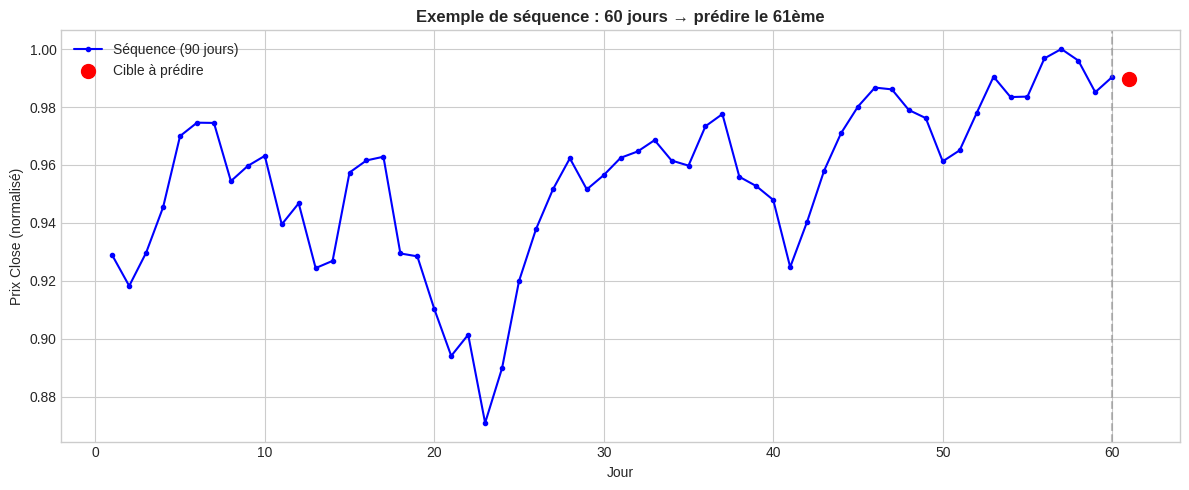


 Explication :
   - Les points bleus = les 60 derniers jours (entrée du modèle)
   - Le point rouge = le jour suivant que le modèle doit prédire


In [532]:
# ============================================
# VISUALISATION D'UNE SÉQUENCE
# ============================================

# Prenons la dernière séquence comme exemple
exemple_idx = -1
exemple_sequence = X[exemple_idx]
exemple_target = y[exemple_idx]

plt.figure(figsize=(12, 5))

# Tracer le prix Close de la séquence
jours = range(1, sequence_length + 1)
plt.plot(jours, exemple_sequence[:, 3], 'b-o', markersize=3, label='Séquence (90 jours)')

# Tracer la cible (jour suivant)
plt.scatter([sequence_length + 1], [exemple_target], color='red', s=100, zorder=5, label='Cible à prédire')

plt.axvline(x=sequence_length, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Jour')
plt.ylabel('Prix Close (normalisé)')
plt.title('Exemple de séquence : 60 jours → prédire le 61ème', fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

print("\n Explication :")
print(f"   - Les points bleus = les {sequence_length} derniers jours (entrée du modèle)")
print(f"   - Le point rouge = le jour suivant que le modèle doit prédire")

In [533]:
# ============================================
# SPLIT TRAIN / TEST
# ============================================

train_size = int(len(X) * CONFIG['train_split'])

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Split des donnees (80/20) :")
print(f"  Train : {X_train.shape[0]} samples")
print(f"  Test  : {X_test.shape[0]} samples")

Split des donnees (80/20) :
  Train : 956 samples
  Test  : 240 samples


In [534]:
# ============================================
# CONVERSION EN TENSEURS PYTORCH
# ============================================

# Conversion en tenseurs
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

# Creation des DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

print(f"DataLoaders crees :")
print(f"  Train batches : {len(train_loader)}")
print(f"  Test batches  : {len(test_loader)}")

DataLoaders crees :
  Train batches : 30
  Test batches  : 8


---

## Section 6 : Architecture du Modèle LSTM

### Comment fonctionne un LSTM ?

Le LSTM (Long Short-Term Memory) est un type de réseau de neurones récurrent qui peut "mémoriser" des informations sur de longues périodes. Il utilise un système de **portes** (gates) pour contrôler le flux d'information :

```
┌─────────────────────────────────────────────────────────────────┐
│                    Cellule LSTM                                 │
├─────────────────────────────────────────────────────────────────┤
│                                                                 │
│   ┌──────────┐   ┌──────────┐   ┌──────────┐                   │
│   │  Forget  │   │  Input   │   │  Output  │                   │
│   │   Gate   │   │   Gate   │   │   Gate   │                   │
│   └────┬─────┘   └────┬─────┘   └────┬─────┘                   │
│        │              │              │                          │
│        ▼              ▼              ▼                          │
│   ┌─────────────────────────────────────┐                      │
│   │          Cell State (mémoire)        │──────────────────→  │
│   └─────────────────────────────────────┘                      │
│                                                                 │
│   - Forget Gate : "Quoi oublier ?" (ex: anciennes tendances)   │
│   - Input Gate  : "Quoi mémoriser ?" (ex: nouveau pattern)     │
│   - Output Gate : "Quoi utiliser ?" (pour la prédiction)       │
│                                                                 │
└─────────────────────────────────────────────────────────────────┘
```

### Notre architecture

```
Entrée : [batch_size, 60, 5]     (60 jours × 5 features)
    │
    ▼
┌─────────────┐
│  LSTM #1    │  (64 neurones)
└─────────────┘
    │ (dropout 20%)
    ▼
┌─────────────┐
│  LSTM #2    │  (64 neurones)
└─────────────┘
    │
    ▼
┌─────────────┐
│   Linear    │  (64 → 1)
└─────────────┘
    │
    ▼
Sortie : [batch_size, 1]         (prédiction du Close)
```

In [535]:
# ============================================
# DEFINITION DU MODELE LSTM
# ============================================

class LSTMModel(nn.Module):
    """
    Modele LSTM pour la prediction de series temporelles.
    
    Architecture :
    - Couches LSTM empilees avec dropout
    - Couche fully connected pour la sortie
    """
    
    def __init__(self, input_size, hidden_size, num_layers, dropout, output_size=1):
        super(LSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Couches LSTM
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Couche fully connected pour la sortie
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: Input tensor (batch_size, sequence_length, input_size)
        
        Returns:
            output: Predictions (batch_size, 1)
        """
        # LSTM forward
        # lstm_out: (batch_size, sequence_length, hidden_size)
        # h_n: (num_layers, batch_size, hidden_size) - dernier hidden state
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # On prend seulement la sortie du dernier timestep
        last_output = lstm_out[:, -1, :]
        
        # Passage dans la couche fully connected
        output = self.fc(last_output)
        
        return output.squeeze()

In [536]:
# ============================================
# INSTANCIATION DU MODELE
# ============================================

# Parametres du modele
input_size = len(features)  # 5 features
hidden_size = CONFIG['hidden_size']
num_layers = CONFIG['num_layers']
dropout = CONFIG['dropout']

# Creation du modele
model = LSTMModel(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout=dropout
).to(device)

print("Architecture du modele :")
print(model)

# Nombre de parametres
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nNombre total de parametres : {total_params:,}")
print(f"Parametres entrainables : {trainable_params:,}")

Architecture du modele :
LSTMModel(
  (lstm): LSTM(5, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Nombre total de parametres : 51,521
Parametres entrainables : 51,521


---

## Section 7 : Entraînement du Modèle

### Les composants de l'entraînement

| Composant | Rôle | Notre choix |
|-----------|------|-------------|
| **Loss Function** | Mesure l'erreur entre prédiction et réalité | MSELoss (Mean Squared Error) |
| **Optimizer** | Met à jour les poids pour minimiser la loss | Adam (adaptatif, efficace) |
| **Learning Rate** | Taille des pas de mise à jour | 0.001 (valeur standard) |

### Pourquoi MSELoss ?

```
MSE = (1/n) × Σ(y_pred - y_true)²

- Pénalise fortement les grandes erreurs (à cause du carré)
- Adaptée aux problèmes de régression (prédire une valeur continue)
```

### Pourquoi Adam ?

- Combine les avantages de plusieurs optimiseurs
- Adapte automatiquement le learning rate pour chaque paramètre
- Fonctionne bien "out of the box" sans trop de tuning

In [537]:
# ============================================
# CONFIGURATION DE L'ENTRAINEMENT
# ============================================

# Fonction de perte : Mean Squared Error
criterion = nn.MSELoss()

# Optimiseur : Adam
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])

print(f"Fonction de perte : MSELoss")
print(f"Optimiseur : Adam (lr={CONFIG['learning_rate']})")
print(f"Epochs : {CONFIG['epochs']}")

Fonction de perte : MSELoss
Optimiseur : Adam (lr=0.0001)
Epochs : 250


In [538]:
# ============================================
# BOUCLE D'ENTRAINEMENT
# ============================================

print("Debut de l'entrainement...")
print("=" * 50)

train_losses = []
epochs = CONFIG['epochs']

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        # Reset des gradients
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(batch_X)
        
        # Calcul de la perte
        loss = criterion(predictions, batch_y)
        
        # Backward pass
        loss.backward()
        
        # Mise a jour des poids
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Moyenne de la perte sur l'epoch
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # Affichage tous les 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1:3d}/{epochs}] - Loss: {avg_loss:.6f}")

print("=" * 50)
print("Entrainement termine !")

Debut de l'entrainement...
Epoch [ 10/250] - Loss: 0.001843
Epoch [ 20/250] - Loss: 0.001246
Epoch [ 30/250] - Loss: 0.001028
Epoch [ 40/250] - Loss: 0.000992
Epoch [ 50/250] - Loss: 0.000973
Epoch [ 60/250] - Loss: 0.000953
Epoch [ 70/250] - Loss: 0.000870
Epoch [ 80/250] - Loss: 0.000801
Epoch [ 90/250] - Loss: 0.000795
Epoch [100/250] - Loss: 0.000740
Epoch [110/250] - Loss: 0.000776
Epoch [120/250] - Loss: 0.000706
Epoch [130/250] - Loss: 0.000656
Epoch [140/250] - Loss: 0.000665
Epoch [150/250] - Loss: 0.000628
Epoch [160/250] - Loss: 0.000637
Epoch [170/250] - Loss: 0.000581
Epoch [180/250] - Loss: 0.000546
Epoch [190/250] - Loss: 0.000558
Epoch [200/250] - Loss: 0.000557
Epoch [210/250] - Loss: 0.000541
Epoch [220/250] - Loss: 0.000509
Epoch [230/250] - Loss: 0.000506
Epoch [240/250] - Loss: 0.000506
Epoch [250/250] - Loss: 0.000457
Entrainement termine !


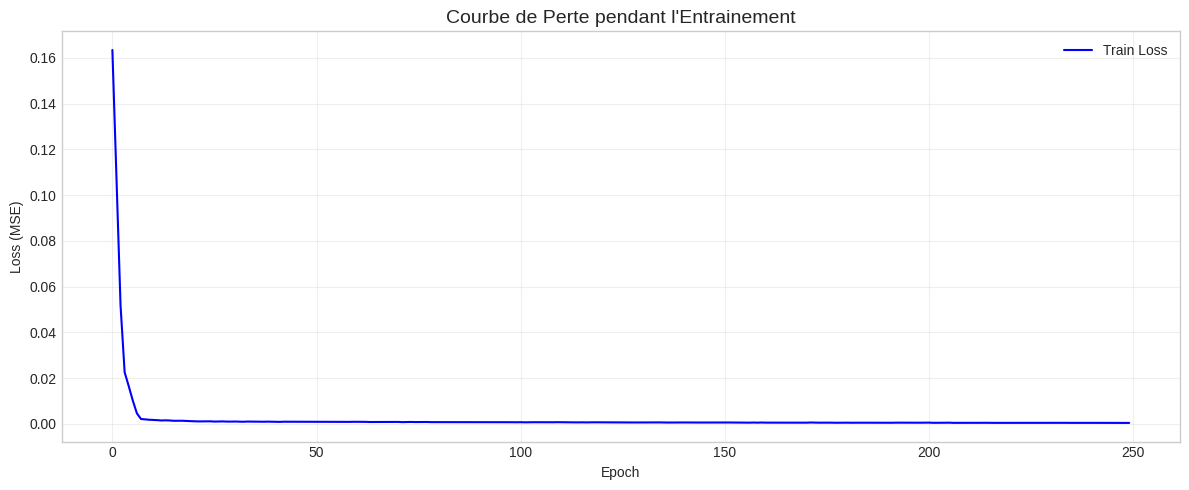

Loss initiale : 0.163452
Loss finale   : 0.000457
Reduction     : 99.7%


In [539]:
# ============================================
# VISUALISATION DE LA COURBE DE PERTE
# ============================================

plt.figure(figsize=(12, 5))
plt.plot(train_losses, color='blue', linewidth=1.5, label='Train Loss')
plt.title('Courbe de Perte pendant l\'Entrainement', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Loss initiale : {train_losses[0]:.6f}")
print(f"Loss finale   : {train_losses[-1]:.6f}")
print(f"Reduction     : {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.1f}%")

---

## Section 8 : Évaluation du Modèle

### Métriques d'évaluation

| Métrique | Description | Interprétation |
|----------|-------------|----------------|
| **RMSE** | Root Mean Squared Error | Erreur moyenne en $ (même unité que le prix) |
| **MAE** | Mean Absolute Error | Erreur absolue moyenne en $ |
| **MAPE** | Mean Absolute Percentage Error | Erreur en % (indépendant de l'échelle) |

```
RMSE = √(MSE) = √[(1/n) × Σ(y_pred - y_true)²]
MAE  = (1/n) × Σ|y_pred - y_true|
MAPE = (100/n) × Σ|(y_pred - y_true) / y_true|
```

In [540]:
# ============================================
# PREDICTIONS SUR LE JEU DE TEST
# ============================================

model.eval()

with torch.no_grad():
    # Predictions sur le train set
    train_predictions = model(X_train_tensor).cpu().numpy()
    # Predictions sur le test set
    test_predictions = model(X_test_tensor).cpu().numpy()

print(f"Predictions effectuees :")
print(f"  Train : {len(train_predictions)} predictions")
print(f"  Test  : {len(test_predictions)} predictions")

Predictions effectuees :
  Train : 956 predictions
  Test  : 240 predictions


In [541]:
# ============================================
# DENORMALISATION DES RESULTATS
# ============================================

def inverse_transform_close(scaled_values, scaler):
    """
    Denormalise les valeurs de Close price.
    
    Le scaler a ete fit sur 5 features, donc on doit creer
    un array factice pour la denormalisation.
    """
    # Creer un array avec des zeros pour les autres features
    dummy = np.zeros((len(scaled_values), 5))
    dummy[:, 3] = scaled_values  # Close est a l'index 3
    
    # Denormaliser
    denormalized = scaler.inverse_transform(dummy)
    
    return denormalized[:, 3]

# Denormalisation
y_train_actual = inverse_transform_close(y_train, scaler)
y_test_actual = inverse_transform_close(y_test, scaler)
train_pred_actual = inverse_transform_close(train_predictions, scaler)
test_pred_actual = inverse_transform_close(test_predictions, scaler)

print("Valeurs denormalisees (en $) :")
print(f"  Test - Reel   : min=${y_test_actual.min():.2f}, max=${y_test_actual.max():.2f}")
print(f"  Test - Predit : min=${test_pred_actual.min():.2f}, max=${test_pred_actual.max():.2f}")

Valeurs denormalisees (en $) :
  Test - Reel   : min=$4982.77, max=$6977.27
  Test - Predit : min=$5166.42, max=$6846.20


In [542]:
# ============================================
# CALCUL DES METRIQUES
# ============================================

def calculate_metrics(actual, predicted):
    """Calcule RMSE, MAE et MAPE."""
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return rmse, mae, mape

# Metriques Train
train_rmse, train_mae, train_mape = calculate_metrics(y_train_actual, train_pred_actual)

# Metriques Test
test_rmse, test_mae, test_mape = calculate_metrics(y_test_actual, test_pred_actual)

print("=" * 50)
print("RESULTATS DU MODELE")
print("=" * 50)
print(f"\n{'Metrique':<15} {'Train':>12} {'Test':>12}")
print("-" * 40)
print(f"{'RMSE ($)':<15} {train_rmse:>12.2f} {test_rmse:>12.2f}")
print(f"{'MAE ($)':<15} {train_mae:>12.2f} {test_mae:>12.2f}")
print(f"{'MAPE (%)':<15} {train_mape:>12.2f} {test_mape:>12.2f}")
print("=" * 50)

RESULTATS DU MODELE

Metrique               Train         Test
----------------------------------------
RMSE ($)               66.31       107.62
MAE ($)                49.96        80.30
MAPE (%)                1.12         1.30


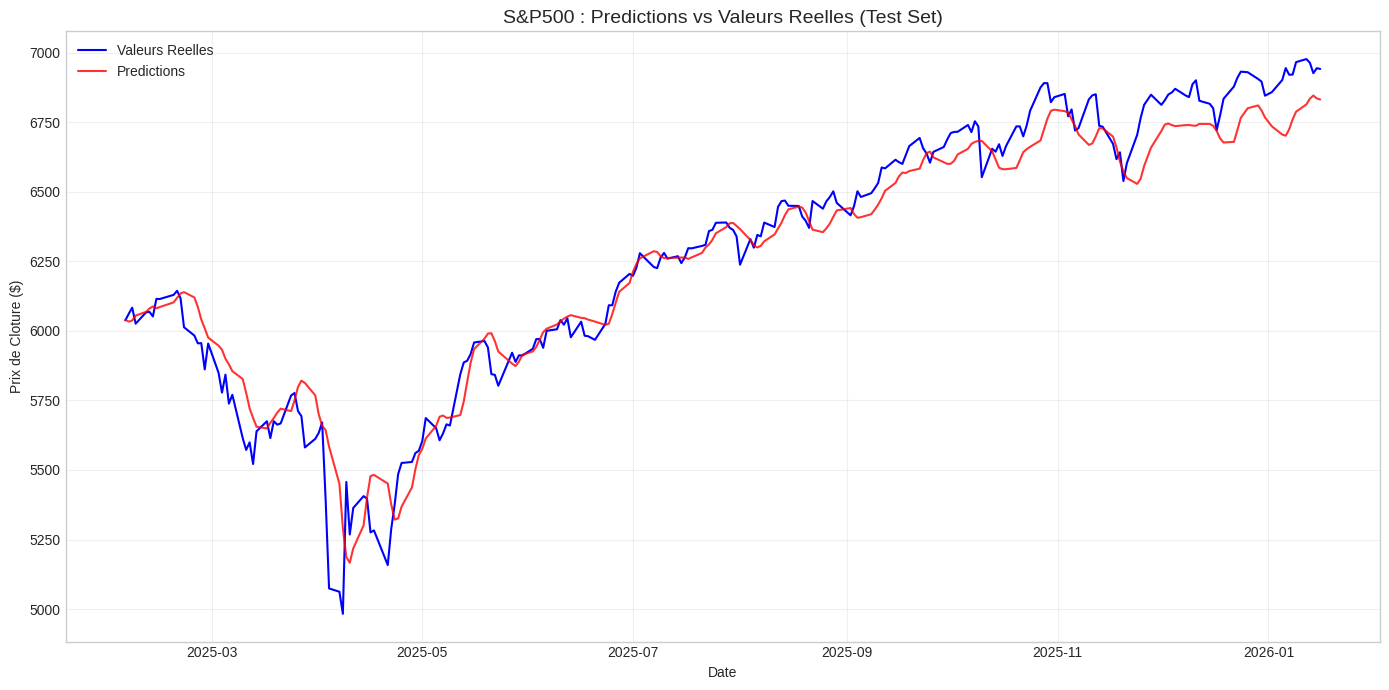

In [543]:
# ============================================
# VISUALISATION : PREDICTIONS VS REEL
# ============================================

# Creer les dates pour le test set
test_dates = df.index[train_size + sequence_length:]

plt.figure(figsize=(14, 7))

# Valeurs reelles
plt.plot(test_dates, y_test_actual, label='Valeurs Reelles', color='blue', linewidth=1.5)

# Predictions
plt.plot(test_dates, test_pred_actual, label='Predictions', color='red', linewidth=1.5, alpha=0.8)

plt.title('S&P500 : Predictions vs Valeurs Reelles (Test Set)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Prix de Cloture ($)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

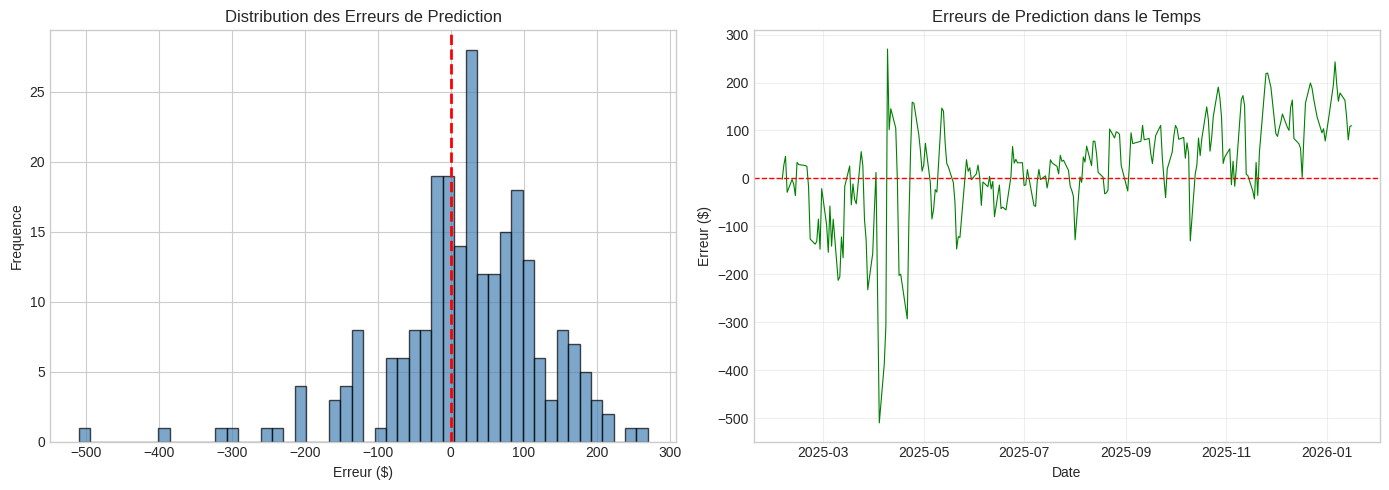

Statistiques des erreurs :
  Moyenne : $22.52
  Ecart-type : $105.24
  Min : $-509.79
  Max : $269.88


In [544]:
# ============================================
# VISUALISATION : ERREURS DE PREDICTION
# ============================================

errors = y_test_actual - test_pred_actual

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution des erreurs
axes[0].hist(errors, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_title('Distribution des Erreurs de Prediction', fontsize=12)
axes[0].set_xlabel('Erreur ($)')
axes[0].set_ylabel('Frequence')

# Erreurs dans le temps
axes[1].plot(test_dates, errors, color='green', linewidth=0.8)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[1].set_title('Erreurs de Prediction dans le Temps', fontsize=12)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Erreur ($)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Statistiques des erreurs :")
print(f"  Moyenne : ${errors.mean():.2f}")
print(f"  Ecart-type : ${errors.std():.2f}")
print(f"  Min : ${errors.min():.2f}")
print(f"  Max : ${errors.max():.2f}")

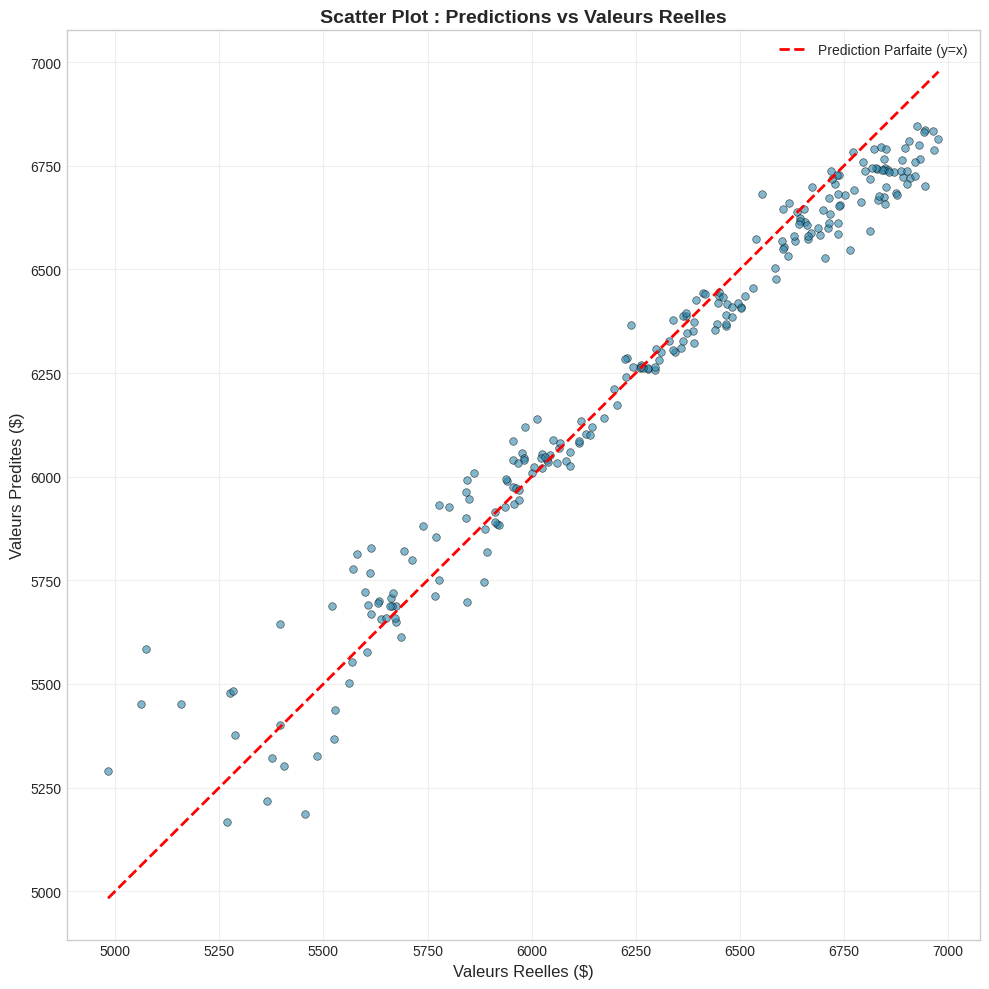


Coefficient de determination (R²) : 0.9511
   - R² = 1 : predictions parfaites
   - R² = 0 : modele aussi bon qu'une moyenne
   - R² < 0 : modele pire qu'une moyenne


In [545]:
# ============================================
# SCATTER PLOT : REEL VS PREDIT
# ============================================

plt.figure(figsize=(10, 10))

# Points de prediction
plt.scatter(y_test_actual, test_pred_actual, alpha=0.6, s=30, c='#2E86AB', edgecolors='black', linewidth=0.5)

# Ligne parfaite (y = x)
min_val = min(y_test_actual.min(), test_pred_actual.min())
max_val = max(y_test_actual.max(), test_pred_actual.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Prediction Parfaite (y=x)')

plt.xlabel('Valeurs Reelles ($)', fontsize=12)
plt.ylabel('Valeurs Predites ($)', fontsize=12)
plt.title('Scatter Plot : Predictions vs Valeurs Reelles', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calcul du R²
from sklearn.metrics import r2_score
r2 = r2_score(y_test_actual, test_pred_actual)
print(f"\nCoefficient de determination (R²) : {r2:.4f}")
print(f"   - R² = 1 : predictions parfaites")
print(f"   - R² = 0 : modele aussi bon qu'une moyenne")
print(f"   - R² < 0 : modele pire qu'une moyenne")

### Discussion sur les Limites


**Limites du modele :**
- Le marche boursier est influenee par de nombreux facteurs externes (actualites, politique, economie mondiale)
- Les patterns passes ne garantissent pas les mouvements futurs
- Le modele capture la tendance generale mais pas les pics de volatilite


---

## Section 9 : Sauvegarde du Modele

Pour reutiliser le modele (notamment dans le dashboard), nous sauvegardons :
- Les poids du modele (`.pth`)
- Le scaler (`.pkl`)
- La configuration et les metriques (`.json`)

In [546]:
# ============================================
# SAUVEGARDE DU MODELE
# ============================================

# Creer le dossier models/ si necessaire
os.makedirs('models', exist_ok=True)

# 1. Sauvegarder les poids du modele
model_path = 'models/lstm_model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
}, model_path)
print(f"Modele sauvegarde : {model_path}")

# 2. Sauvegarder le scaler
scaler_path = 'models/scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler sauvegarde : {scaler_path}")

# 3. Sauvegarder la configuration et les metriques
config_path = 'models/config.json'
config_to_save = {
    'config': CONFIG,
    'model_params': {
        'input_size': input_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'dropout': dropout,
    },
    'metrics': {
        'train_rmse': float(train_rmse),
        'train_mae': float(train_mae),
        'train_mape': float(train_mape),
        'test_rmse': float(test_rmse),
        'test_mae': float(test_mae),
        'test_mape': float(test_mape),
    },
    'data_info': {
        'total_samples': len(df),
        'train_samples': train_size,
        'test_samples': len(X_test),
        'features': features,
    },
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
}

with open(config_path, 'w') as f:
    json.dump(config_to_save, f, indent=2)
print(f"Configuration sauvegardee : {config_path}")

Modele sauvegarde : models/lstm_model.pth
Scaler sauvegarde : models/scaler.pkl
Configuration sauvegardee : models/config.json


In [547]:
# ============================================
# RESUME FINAL
# ============================================

print("\n" + "=" * 60)
print("RESUME DU PROJET")
print("=" * 60)

print(f"\n1. DONNEES")
print(f"   - Source : Yahoo Finance (yfinance)")
print(f"   - Ticker : {TICKER}")
print(f"   - Periode : {PERIOD}")
print(f"   - Total : {len(df)} jours de trading")

print(f"\n2. MODELE")
print(f"   - Architecture : LSTM")
print(f"   - Couches : {num_layers}")
print(f"   - Hidden size : {hidden_size}")
print(f"   - Parametres : {total_params:,}")

print(f"\n3. ENTRAINEMENT")
print(f"   - Epochs : {epochs}")
print(f"   - Batch size : {CONFIG['batch_size']}")
print(f"   - Learning rate : {CONFIG['learning_rate']}")

print(f"\n4. RESULTATS (Test Set)")
print(f"   - RMSE : ${test_rmse:.2f}")
print(f"   - MAE  : ${test_mae:.2f}")
print(f"   - MAPE : {test_mape:.2f}%")

print(f"\n5. FICHIERS SAUVEGARDES")
print(f"   - data/sp500_data.csv")
print(f"   - models/lstm_model.pth")
print(f"   - models/scaler.pkl")
print(f"   - models/config.json")

print("\n" + "=" * 60)
print("Projet termine avec succes !")
print("=" * 60)


RESUME DU PROJET

1. DONNEES
   - Source : Yahoo Finance (yfinance)
   - Ticker : ^GSPC
   - Periode : 5y
   - Total : 1256 jours de trading

2. MODELE
   - Architecture : LSTM
   - Couches : 2
   - Hidden size : 64
   - Parametres : 51,521

3. ENTRAINEMENT
   - Epochs : 250
   - Batch size : 32
   - Learning rate : 0.0001

4. RESULTATS (Test Set)
   - RMSE : $107.62
   - MAE  : $80.30
   - MAPE : 1.30%

5. FICHIERS SAUVEGARDES
   - data/sp500_data.csv
   - models/lstm_model.pth
   - models/scaler.pkl
   - models/config.json

Projet termine avec succes !
